In [ ]:
import numpy as np 
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.linear_model import LogisticRegression

In [ ]:
data = pd.read_csv('course_lead_scoring.csv')
data.head()

In [ ]:
# data cleaning- adding NaNs and 0s

for col in data.select_dtypes(include=['float','int']).columns:
    # leave numeric NaNs alone or fill with 0 or a numeric sentinel
    data.fillna({col:0}, inplace=True)

for col in data.select_dtypes(exclude=['float','int']).columns:
    data.fillna({col:'NA'}, inplace=True)

data.industry.value_counts()

<Axes: >

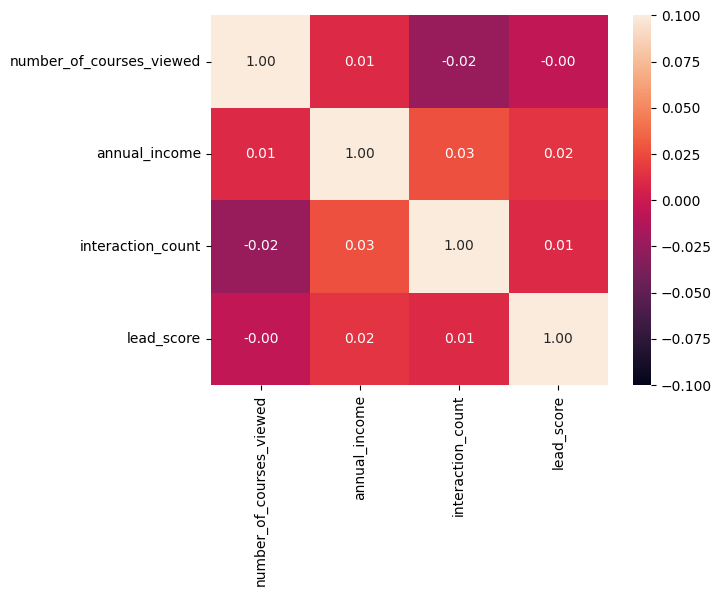

In [337]:
# corr btw numerical features
dataNumeric = data.select_dtypes(include=['float','int'])
dataNumericFeatures = dataNumeric.drop(columns=['converted'])

sns.heatmap(dataNumericFeatures.corr(), annot=True, fmt=".2f", vmin=-0.1, vmax = 0.1)

In [328]:
# Q3
# split data and calculate mutual information score

dataFeatures = data.drop(columns=['converted'])
X_trainValData, X_testData, y_trainValData, y_testData = train_test_split(dataFeatures, data['converted'], test_size=0.2, random_state=42, shuffle=True, stratify=data['converted'])
X_trainData, X_valData, y_trainData, y_valData = train_test_split(X_trainValData, y_trainValData, test_size=0.25, random_state=42, shuffle=True, stratify=y_trainValData)


# one hot encoding for categorical features using get dummies
# X_trainData_ohe = pd.get_dummies(X_trainData)
# X_valData_ohe = pd.get_dummies(X_valData)
# X_testData_ohe = pd.get_dummies(X_testData)
# dropNaCols = X_trainData_ohe.columns[X_trainData_ohe.columns.str.contains('NA')]
# X_trainData_ohe = X_trainData_ohe.drop(columns=dropNaCols)
# X_valData_ohe = X_valData_ohe.drop(columns=dropNaCols)
# X_testData_ohe = X_testData_ohe.drop(columns=dropNaCols)    


# one hot encoding for categorical features using SCIKIT learn ohe- gives only cat columuns
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
catCols = data.select_dtypes(include=['object']).columns
X_trainData_catOhe = ohe.fit_transform(X_trainData[catCols])
X_trainData_catOhe= pd.DataFrame(X_trainData_catOhe, columns =ohe.get_feature_names_out(catCols))
X_valData_catOhe = ohe.transform(X_valData[catCols])
X_valData_catOhe= pd.DataFrame(X_valData_catOhe, columns= ohe.get_feature_names_out(catCols))
X_testData_catOhe = ohe.transform(X_testData[catCols])
X_testData_catOhe= pd.DataFrame(X_testData_catOhe, columns= ohe.get_feature_names_out(catCols))


# drop any one-hot columns that represent the placeholder 'NA' category
drop_na_cols = [c for c in X_trainData_catOhe.columns if 'NA' in c]
if drop_na_cols:
    X_trainData_catOhe = X_trainData_catOhe.drop(columns=drop_na_cols)
    X_valData_catOhe = X_valData_catOhe.drop(columns=drop_na_cols)
    X_testData_catOhe = X_testData_catOhe.drop(columns=drop_na_cols)

# compute mutual information on the cleaned feature set
miScores = mutual_info_classif(X_trainData_catOhe, y_trainData, discrete_features='auto', random_state=42)
mi_series = pd.Series(miScores, index= X_trainData_catOhe.columns).sort_values(ascending=False)


mainFeatures = catCols.to_list()
mi_mainCat = {}
for i in range(len(mainFeatures)):
    mi_mainCat[mainFeatures[i]] = mi_series[mi_series.index.str.contains(mainFeatures[i])].sum().item()
pd.Series(mi_mainCat).idxmax()

'location'

In [329]:
# Q4
# adding the numberic data to ohe

X_trainData_ohe = pd.concat([X_trainData_catOhe, X_trainData.select_dtypes(include=['float','int']).reset_index(drop=True)], axis=1)
X_valData_ohe = pd.concat([X_valData_catOhe, X_valData.select_dtypes(include=['float','int']).reset_index(drop=True)], axis=1)
X_testData_ohe = pd.concat([X_testData_catOhe, X_testData.select_dtypes(include=['float','int']).reset_index(drop=True)], axis=1)   

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

model.fit(X_trainData_ohe, y_trainData)
y_val_pred = model.predict(X_valData_ohe)
y_train_pred = model.predict(X_trainData_ohe)
val_accuracy = accuracy_score(y_valData, y_val_pred)
train_accuracy = accuracy_score(y_train_pred, y_trainData)
val_precision = precision_score(y_valData, y_val_pred)
test_accuracy = accuracy_score(y_testData, model.predict(X_testData_ohe))
print(f'Validation Accuracy: {val_accuracy:.2f}')
print(f'Training accuracy: {train_accuracy:.2f}')
print(f'Test accuracy: {test_accuracy:.2f}')


Validation Accuracy: 0.73
Training accuracy: 0.74
Test accuracy: 0.71


In [332]:
#Q5
mainFeatures =dataFeatures.columns.to_list()
valAcc=[]
trainAcc=[]
testAcc=[]
effectOnAcc = {'feature': [], 'training': [], 'validation': [], 'testing': []}


for i in range(len(mainFeatures)):

    oheColsCurr =X_trainData_ohe.columns.str.contains(mainFeatures[i], case=False, na=False)
    currTrainData = X_trainData_ohe[X_trainData_ohe.columns[~oheColsCurr]]
    currValData = X_valData_ohe[X_valData_ohe.columns[~oheColsCurr]]
    currTestData = X_testData_ohe[X_testData_ohe.columns[~oheColsCurr]]
    
    model.fit(currTrainData, y_trainData)

    curr_y_train_pred = model.predict(currTrainData)
    trainAcc.append(accuracy_score(curr_y_train_pred, y_trainData))
    
    curr_y_val_pred = model.predict(currValData)
    valAcc.append(accuracy_score(y_valData, curr_y_val_pred))

    curr_y_test_pred = model.predict(currTestData)
    testAcc.append(accuracy_score(y_testData, curr_y_test_pred))

    effectOnAcc['feature'].append(mainFeatures[i])
    effectOnAcc['training'].append(round(abs(train_accuracy - trainAcc[i]),6))
    effectOnAcc['validation'].append(round(abs(val_accuracy - valAcc[i]),6))
    effectOnAcc['testing'].append(round(abs(test_accuracy - testAcc[i]),6))


pd.DataFrame.from_dict(effectOnAcc)

,feature,training,validation,testing
0,lead_source,0.003425,0.006826,0.006826
1,industry,0.002283,0.000000,0.003413
2,number_of_courses_viewed,0.113014,0.109215,0.095563
3,annual_income,0.125571,0.129693,0.133106
4,employment_status,0.002283,0.003413,0.020478
5,location,0.002283,0.000000,0.003413
6,interaction_count,0.117580,0.112628,0.092150
7,lead_score,0.002283,0.003413,0.006826


In [ ]:
#Q6
cVals = [0.01, 0.1, 1, 10, 100]
cAccuracy = {}

for i in range(len(cVals)):
    model = LogisticRegression(solver='liblinear', C=cVals[i], max_iter=1000, random_state=42)
    model.fit(X_trainData_ohe, y_trainData)

    curr_yVal_pred = model.predict(X_valData_ohe)
    cAccuracy[cVals[i]] = accuracy_score(curr_yVal_pred, y_valData)

pd.Series(cAccuracy)

0.01      0.733788
0.10      0.730375
1.00      0.730375
10.00     0.730375
100.00    0.730375
dtype: float64